# Beta-diversity and associations with TB disease manifestations

Author: Monica R. Ticlla Ccenhua <br>
e-mail: mticlla@gmail.com monicaroxana.ticllaccenhua@unibas.ch

**Summary**

to investigate if compositional and structural changes of the microbial communities in the sputum of TB patients were associated with disease manifestations of pulmonary TB, we performed transformation-based redundant analysis (tb-RDA) with stepwise selection of interaction terms, and Permutational Analysis of Variance (PERMANOVA) as implemented in the R-package _vegan_ v2.5. Response variables were CLR-transformed genus-level abundances. Continuous explanatory variables were always scaled. When comparing means among groups, _p-values_ were adjusted for multiple comparisons following Holm-Bonferroni method.


In [1]:
report_date = %env REPORT_DATE
print(report_date)

2020-07-20


## 0. Set-up working environment

**Set-up working directory**

In [2]:
%%capture
cd ../

**Import python modules**

In [3]:
%load_ext rpy2.ipython

.Rprofile: Setting Swiss repository



**Import R packages**

In [4]:
%%capture
%%R
library(phyloseq)
library(ggplot2)
library(hrbrthemes)
hrbrthemes::import_roboto_condensed()
library(RColorBrewer)
library(grid)
library(gridExtra)
library(zCompositions)
library(factoextra)
library(vegan)
library(ggpubr)
library(ggrepel)
library("scales")

options("width"=200)

## 1. Input files

### 1.1 16S-AS taxonomic profiles

**Taxonomy table**

In [5]:
%%R
# Loading the taxonomy table
# --------------------------
#' Convert taxonomy table produced by QIIME2 to a 7-ranks data frame
#'
#' @param qiime2_taxonomy A data frame with columns c('Taxon', 'Confidence')
#' @return The taxonomy table as dataframe with seven columns, the seven taxonomic ranks.
qiime2taxonomy_to_df <- function(qiime2_taxonomy){
    features_ids <- rownames(qiime2_taxonomy)
    taxon_ranks_n = 7
    taxon_rank_names = c("Kingdom","Phylum","Class","Order","Family","Genus","Species")
    taxonomies = sapply(qiime2_taxonomy$Taxon, 
                        function(x,nranks){
                            taxonomy_vector = strsplit(x,'; ')[[1]]
                            na_vector = rep(NA,nranks-length(taxonomy_vector))
                            c(taxonomy_vector,na_vector)}, 
                        taxon_ranks_n)
    taxonomies = data.frame(matrix(taxonomies, 
                                   nrow=length(features_ids), 
                                   ncol=taxon_ranks_n, byrow=TRUE), 
                            row.names=features_ids, 
                            stringsAsFactors=FALSE)
    colnames(taxonomies) <- taxon_rank_names
    return(taxonomies)
}

# Load taxonomies
asv16s_taxonomy_table_file <- './data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/exported/taxonomy.tsv'
asv16s_taxonomy_table <- read.table(asv16s_taxonomy_table_file, header=TRUE, sep='\t', stringsAsFactors=FALSE, 
                                    quote="", check.names=FALSE, row.names=1)
asv16s_taxonomy_table <- qiime2taxonomy_to_df(asv16s_taxonomy_table)
print(dim(asv16s_taxonomy_table))
print(asv16s_taxonomy_table[0:3,0:3])

cat("\nNr of ASVs: ")
cat(dim(asv16s_taxonomy_table)[1])

cat("\nNr of taxonomic levels: ")
cat(dim(asv16s_taxonomy_table)[2])

# Re-format taxonomy table for phyloseq
# Replace non-assigned taxonomy ranks(e.g p__) with NA
is_undefined_rank <- t(unlist(apply(asv16s_taxonomy_table, 1, 
                                    function(x){x %in% c("k__","p__","c__","o__","f__","g__","s__")})))
asv16s_taxonomy_table_ps <- asv16s_taxonomy_table
asv16s_taxonomy_table_ps[ is_undefined_rank ] <- NA

[1] 28284     7
                                     Kingdom           Phylum          Class
0000134bb4f9a56941dd1d0206a600d8 k__Bacteria p__Bacteroidetes c__Bacteroidia
00032a9354651fef5c866ec3f9cdca0d k__Bacteria p__Bacteroidetes c__Bacteroidia
000374910b98b14cc5724af75f294b87 k__Bacteria p__Bacteroidetes c__Bacteroidia

Nr of ASVs: 28284
Nr of taxonomic levels: 7

**Abundance table**

In [6]:
%%R
# Loading the feature table
# -------------------------
asv16s_qiime2_feature_table_file <- "./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam/decontam_table.tsv"
asv16s_qiime2_feature_table <- read.table(asv16s_qiime2_feature_table_file, header=TRUE, sep='\t', 
                                          stringsAsFactors=FALSE, quote = "", check.names=FALSE, row.names=1, 
                                          comment.char="", skip=1)

print(asv16s_qiime2_feature_table[0:3,0:3])

# Create phyloseq object
# ----------------------
# Lets create the phyloseq object (feature/otu table and taxonomy tables merged)
asv16s_feature_table_ps <- phyloseq(otu_table(asv16s_qiime2_feature_table, 
                                              taxa_are_rows=TRUE), 
                                    tax_table(as.matrix(asv16s_taxonomy_table_ps)))
print(asv16s_feature_table_ps)


# Remove samples with less than 12000 total reads
asv16s_feature_table_ps <- prune_samples(sample_sums(asv16s_feature_table_ps) >=12000, 
                                         asv16s_feature_table_ps)

# remove ASV with abundance zero
asv16s_feature_table_ps = filter_taxa(asv16s_feature_table_ps, function(x){sum(x) > 0}, TRUE)

cat("\nContent of Phyloseq object: \n")
print(asv16s_feature_table_ps)

                                 A00030 A00034 A00036
0000134bb4f9a56941dd1d0206a600d8      0      0      0
00032a9354651fef5c866ec3f9cdca0d      0      0      0
000374910b98b14cc5724af75f294b87      0      0      0
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 28274 taxa and 335 samples ]
tax_table()   Taxonomy Table:    [ 28274 taxa by 7 taxonomic ranks ]

Content of Phyloseq object: 
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 27668 taxa and 307 samples ]
tax_table()   Taxonomy Table:    [ 27668 taxa by 7 taxonomic ranks ]


**Sequencing summaries**

In [7]:
%%R
asv16s_stats_file <- "./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/denoising-stats_run123.tsv"
asv16s_stats <- read.csv(asv16s_stats_file, sep="\t", header=TRUE, row.names=1)
print(head(asv16s_stats))
cat("\nNr of samples: ")
cat(dim(asv16s_stats)[1])

cat("\n---\n")
cat("Total retained: \n")
cat(sum(asv16s_stats$non.chimeric))

       input filtered denoised non.chimeric perc_kept
A00030 69471    35777    33346        23903  34.40716
A00034 46103    25102    24765        19104  41.43765
A00036 59728    34850    34422        26914  45.06094
A00038 53641    29543    28367        17434  32.50126
A00053   440      121       49           49  11.13636
A00056 35483    18274    17893        15719  44.30009

Nr of samples: 335
---
Total retained: 
12384275

### 1.2 Genus-level interaction network

In [8]:
%%R
asv16s_bacteria_genus.ig2_file <- "./data/processed/asv16s_genus_level_network.RDA"
load(asv16s_bacteria_genus.ig2_file)
summary(asv16s_bacteria_genus.ig2)

IGRAPH df7afce UNW- 147 183 -- 
+ attr: name (v/c), label (v/c), RSD (v/n), Abundance (v/n), Phylum (v/c), weight (e/n), beta (e/n), sign (e/c)


### 1.3 Host and sample metadata

**Host's clinical data**

In [9]:
%%R
# Load samples metadata
#-----------------------
sample_medatata_file <- './data/interim/host_metadata_extended.tsv'
sample_metadata <- read.table(sample_medatata_file, sep='\t', header=TRUE, row.names=1, 
                              na.strings = c('.',' ','','NA','<NA>'))

## Define the levels of categorical variables:
delaymedtp_cat2_levels <- c('no','amoxycillin','amoxycillin+ampicillin','amoxycillin+cloxacillin',
                            'amoxycillin+ampicillin+cloxacillin','other-medications')
sample_metadata$delaymedtp_cat2 <- factor(sample_metadata$delaymedtp_cat2, levels=delaymedtp_cat2_levels)
print(summary(sample_metadata$delaymedtp_cat2), nrows=2)

delaymed_3cat_levels <- c('No','Penicillins','Other')
sample_metadata$delaymed_3cat <- factor(sample_metadata$delaymed_3cat, levels=delaymed_3cat_levels)
print(summary(sample_metadata$delaymed_3cat))

sample_metadata$smear_grading_bin <- factor(sample_metadata$smear_grading_bin, levels=c('Low','High'))
print(summary(sample_metadata$smear_grading_bin))

xraysevere.levels                 <- c("Normal", "Mild/moderate", "Severe")
sample_metadata$xraysevere        <- factor(sample_metadata$xraysevere, 
                                            levels = xraysevere.levels, ordered=TRUE)
print(summary(sample_metadata$xraysevere))

tbscore_bin.levels                <- c("Mild", "Severe")
sample_metadata$tbscore_bin       <- factor(sample_metadata$tbscore_bin, 
                                            levels = tbscore_bin.levels, ordered=TRUE)
print(summary(sample_metadata$tbscore_bin))

age.levels                        <- c("<25", "25-34", "35-44", ">44")
sample_metadata$age_cat           <- factor(sample_metadata$age_cat, levels=age.levels)
print(summary(sample_metadata$age_cat))

#sex.levels                        <- c("male","female")
sex.levels                        <- c("Male","Female")
sample_metadata$male              <- factor(sample_metadata$male, levels = sex.levels)
print(summary(sample_metadata$male))

#bmi_cat.levels                    <- c("BMI >=18.5", "BMI <18.5")
bmi_cat.levels                    <- c("Normal/Obese BMI>=18.5", "Underweight BMI<18.5")
sample_metadata$bmi_cat           <- factor(sample_metadata$bmi_cat, 
                                            levels = bmi_cat.levels)
print(summary(sample_metadata$bmi_cat))

#season.levels                     <- c("Short Rain", "Long Rain", "Dry")
season.levels                     <- c("Short Rains (Oct. - Feb.)", "Long Rains (March - May)", "Dry (June - Sept.)")
sample_metadata$season            <- factor(sample_metadata$season, levels = season.levels)
print(summary(sample_metadata$season))

# CXR lesions
cavitation.levels           <- c("Absent","Present")
sample_metadata$caviation   <- factor(sample_metadata$caviation, levels=cavitation.levels, ordered=FALSE)
print(summary(sample_metadata$caviation))

infiltration.levels           <- c("Absent","Present")
sample_metadata$filtration   <- factor(sample_metadata$filtration, levels=infiltration.levels, ordered=FALSE)
print(summary(sample_metadata$filtration))

effusion.levels           <- c("Absent","Present")
sample_metadata$effusion   <- factor(sample_metadata$effusion, levels=effusion.levels, ordered=FALSE)
print(summary(sample_metadata$effusion))

lymphnode.levels           <- c("Absent","Present")
sample_metadata$lymphnode   <- factor(sample_metadata$lymphnode, levels=lymphnode.levels, ordered=FALSE)
print(summary(sample_metadata$lymphnode))

micronode.levels           <- c("Absent","Present")
sample_metadata$micronode   <- factor(sample_metadata$micronode, levels=micronode.levels, ordered=FALSE)
print(summary(sample_metadata$micronode))

anemia_levels <- c('No anemia','Mild','Moderate','Severe')
sample_metadata$anemia_status <- factor(sample_metadata$anemia_status, levels=anemia_levels, ordered=TRUE)
print(summary(sample_metadata$anemia_status))

sample_metadata$anemia_bin <- factor(sample_metadata$anemia_bin, levels=c("No","Yes"))
print(summary(sample_metadata$anemia_bin))

nutritional_status_levels <- c('Normal weight','Underweight','Obesity')
sample_metadata$nutrition_status <- factor(sample_metadata$nutrition_status, levels=nutritional_status_levels, 
                                           ordered=FALSE)
print(summary(sample_metadata$nutrition_status))

sample_metadata$xray_findings <- factor(sample_metadata$xray_findings, levels=c("Normal","Abnormal"))
print(summary(sample_metadata$xray_findings))

#cxr_categories_levels <- c("Normal","filtration","filtration_cavitation","filtration_other","effusion","other")
cxr_categories_levels <- c("Normal","Infiltration","Infiltration & Cavitation","Infiltration (other)","Pleural effusion","Other")
sample_metadata$cxr_categories <- factor(sample_metadata$cxr_categories, levels=cxr_categories_levels)
print(summary(sample_metadata$cxr_categories))

sample_metadata$lineage134 <- factor(sample_metadata$lineage134, levels=c('L3','L1','L4'))
print(summary(sample_metadata$lineage134))

sample_metadata$islineage3 <- sample_metadata$lineage
sample_metadata$islineage3 <- plyr::mapvalues(sample_metadata$islineage3, 
                                              from=c("L1","L2","L3","L4"), 
                                              to=c("Non-L3","Non-L3","L3","Non-L3")
                                             )
print(summary(sample_metadata$islineage3))

cat("\n Number of samples in dataset: ")
cat(dim(sample_metadata)[1])
cat("\n Number of variables in dataset: ")
cat(dim(sample_metadata)[2])

                                no                        amoxycillin             amoxycillin+ampicillin            amoxycillin+cloxacillin amoxycillin+ampicillin+cloxacillin 
                                20                                 31                                 90                                 47                                 96 
                 other-medications 
                                50 
         No Penicillins       Other 
         20         264          50 
 Low High 
 127  207 
       Normal Mild/moderate        Severe          NA's 
           59           132            56            87 
  Mild Severe 
   223    111 
  <25 25-34 35-44   >44 
   61   129    95    49 
  Male Female 
   240     94 
Normal/Obese BMI>=18.5   Underweight BMI<18.5 
                   158                    176 
Short Rains (Oct. - Feb.)  Long Rains (March - May)        Dry (June - Sept.)                      NA's 
                      120                        74      

**Table with mapping IDs**

In [10]:
%%R
asv16s_mapping_ids_file <- "./data/raw/tz_spt_cases/sample_ids_mapping.txt"
wms_mapping_ids_file <- "data/raw/wms/wms_cases/sample_ids_mapping.txt"

asv16s_mapping_ids <- read.table(asv16s_mapping_ids_file, header=TRUE, sep='\t',
                                 stringsAsFactors=FALSE, row.names=1)
wms_mapping_ids <- read.table(wms_mapping_ids_file, header=TRUE, sep='\t',
                                 stringsAsFactors=FALSE, row.names=1, na.strings = c("NA",""))

print(head(asv16s_mapping_ids, n=3))
print(head(wms_mapping_ids, n=3))

       SpecimenID SubjectID seq_run
A00030     S00394    H00388    run1
A00034     S00426    H00421    run1
A00036     S00173    H00173    run1
       SpecimenID SubjectID
M00001     S00181    H00183
M00002     S00375    H00368
M00004        NC3      <NA>


## 2 Centered-log ratio (CLR) transformation of genera abundances

**Extract genera abundances**

In [11]:
%%R
# Extract counts
# ---------------
asv16s_bacteria_genus_counts_ps <- tax_glom(subset_taxa(asv16s_feature_table_ps, Kingdom=="k__Bacteria"), 
                                            "Genus", NArm=FALSE)

# Extract relative abundances
# ---------------------------
asv16s_bacteria_genus_ra <- otu_table(transform_sample_counts(asv16s_bacteria_genus_counts_ps,
                                                              function(x){(x/sum(x))*100}))
asv16s_bacteria_genus_ra <- t(asv16s_bacteria_genus_ra)
print(head(asv16s_bacteria_genus_ra))

OTU Table:          [522 taxa and 6 samples]
                     taxa are columns
       00054bda86b78c430a861fa6dbd577f9 005437e2403405bc5930d766a3a9a44d 0054e5be5a0d5094620e9bcc93ec8207 005d8a7030eb05c419b56514e7157ed4 00ffa6dec3ed0e17e1ffe754cdb8c629
A00030                        0.0334686                                0                                0                                0                        0.0334686
A00034                        0.0000000                                0                                0                                0                        0.0000000
A00036                        0.0000000                                0                                0                                0                        0.0000000
A00038                        0.0000000                                0                                0                                0                        0.0000000
A00056                        0.0000000                  

**CLR transformation**

In [12]:
%%R
# CLR-transformation of counts
# ----------------------------
asv16s_bacteria_genus_counts_clr <-  otu_table(asv16s_bacteria_genus_counts_ps)

# Filter rare genus
# Keep those which are at least 5% prevalent in the dataset
prevalence_cutoff <- round(5*(dim(asv16s_bacteria_genus_counts_clr)[2])/100)
cat("\nPrevalence cut-off: ")
cat(prevalence_cutoff)
genus_is_abv_cutoff <- as.vector(rowSums(asv16s_bacteria_genus_counts_clr>0) >= prevalence_cutoff)
asv16s_bacteria_genus_counts_clr <- asv16s_bacteria_genus_counts_clr[genus_is_abv_cutoff,]

# Remove samples with zero totals
sample_has_zero_totals <- as.vector(colSums(asv16s_bacteria_genus_counts_clr)==0)
if(sum(sample_has_zero_totals)>0){
    cat("\nSamples with zero totals removed: ")
    cat(colnames(asv16s_bacteria_genus_counts_clr)[sample_has_zero_totals])
    asv16s_bacteria_genus_counts_clr <- asv16s_bacteria_genus_counts_clr[,!sample_has_zero_totals]
}
cat("\nDimensions(genera-by-samples) of filtered table: ",
    dim(asv16s_bacteria_genus_counts_clr),'\n')

# Then, replace zeroes, returns a sample-by-features table (samples as rows)
asv16s_bacteria_genus_counts_clr <- cmultRepl(t(asv16s_bacteria_genus_counts_clr), 
                                              label=0, method="CZM", output="p-counts")
# Finally, apply CLR-transformation
asv16s_bacteria_genus_counts_clr <- t(apply(asv16s_bacteria_genus_counts_clr, 1, 
                                            function(x){log(x) - mean(log(x))}))
print(asv16s_bacteria_genus_counts_clr[1:5,1:2])


Prevalence cut-off: 15
Dimensions(genera-by-samples) of filtered table:  147 307 
No. corrected values:  1575 
       00054bda86b78c430a861fa6dbd577f9 00ffa6dec3ed0e17e1ffe754cdb8c629
A00030                        0.9746196                        0.9746196
A00034                       -0.6501133                       -0.6501133
A00036                       -1.1481609                       -1.1481609
A00038                       -1.7419236                       -1.2766701
A00056                       -2.2738214                       -1.7088573


## 3. Testing associations with beta-diversity

**Variables to be included in models**

In [13]:
%%R
clinical_metadata_vars <- c('xray_findings','cxr_categories','tbscore_bin','smear_grading_bin', 'islineage3','lineage134', 
                           'tbdelay','delaymed', 'delaymed_3cat', 'male', 'age_cat', 'bmi_cat', 'anemia_bin',
                           'hiv', 'viral', 'helminth', 'bacterial', 'smoking', 'alcoholabuse', 'season',
                            'filtration','caviation','micronode','effusion','lymphnode')

clinical_metadata_table <- asv16s_mapping_ids[sample_names(asv16s_feature_table_ps),]
clinical_metadata_table <- cbind(clinical_metadata_table, 
                                 sample_metadata[clinical_metadata_table$SubjectID,clinical_metadata_vars])
# Add sequencing depth
clinical_metadata_table$seq_depth <- asv16s_stats[rownames(clinical_metadata_table), "input"]
clinical_metadata_table$seq_depth_sc <- scale(clinical_metadata_table$seq_depth)


### 3.1 Transformation-based redundancy analysis (tb-RDA) to simultaneously assess the marginal effects of abnormal CXR-findings and high mycobacterial load in sputum

**Model selection**

In [14]:
%%R
# variables in RDA
vars_included <- c("xray_findings","cxr_categories","smear_grading_bin","tbdelay",
                   "male","age_cat","bmi_cat","anemia_bin",
                   "hiv","viral","bacterial","helminth","smoking","alcoholabuse",
                   "delaymed_3cat","season","seq_depth_sc","seq_run")

asv16s_sample_metadata_for_rda <-na.omit(clinical_metadata_table[,vars_included])


# Forward selection of interactions
# ----------------------------------
# Minimal model
asv16s_genus_clr_minimal_rda <- rda(scale(asv16s_bacteria_genus_counts_clr[rownames(asv16s_sample_metadata_for_rda),], 
                                          center=TRUE, scale=FALSE) ~ 
                                    cxr_categories + smear_grading_bin + tbdelay + delaymed_3cat +
                                    age_cat + male + bmi_cat + anemia_bin + 
                                    hiv + viral + bacterial + helminth + smoking + alcoholabuse + 
                                    season + seq_run + seq_depth_sc, 
                                    data=asv16s_sample_metadata_for_rda)

# Full model (with interactions)
asv16s_genus_clr_full_rda <- rda(scale(asv16s_bacteria_genus_counts_clr[rownames(asv16s_sample_metadata_for_rda),], 
                                          center=TRUE, scale=FALSE) ~ 
                                 cxr_categories + smear_grading_bin + tbdelay + delaymed_3cat +
                                 age_cat + male + bmi_cat + anemia_bin + 
                                 hiv + viral + bacterial + helminth + smoking + alcoholabuse + 
                                 season + seq_run + seq_depth_sc +
                                 cxr_categories*bmi_cat + 
                                 cxr_categories*anemia_bin + 
                                 cxr_categories*hiv + 
                                 cxr_categories*viral + 
                                 cxr_categories*bacterial + 
                                 cxr_categories*helminth + 
                                 cxr_categories*smoking + 
                                 cxr_categories*alcoholabuse + 
                                 cxr_categories*season + 
                                 smear_grading_bin*bmi_cat + 
                                 smear_grading_bin*anemia_bin + 
                                 smear_grading_bin*hiv + 
                                 smear_grading_bin*viral + 
                                 smear_grading_bin*bacterial + 
                                 smear_grading_bin*helminth + 
                                 smear_grading_bin*smoking + 
                                 smear_grading_bin*alcoholabuse + 
                                 smear_grading_bin*season, 
                                 data=asv16s_sample_metadata_for_rda)

# Step-forward selection
asv16s_genus_clr_selected_ordir2step <- ordiR2step(asv16s_genus_clr_minimal_rda, 
                                            scope=formula(asv16s_genus_clr_full_rda), 
                                            direction="forward", permutations=9999)


Step: R2.adj= 0.02804184 
Call: scale(asv16s_bacteria_genus_counts_clr[rownames(asv16s_sample_metadata_for_rda),      ], center = TRUE, scale = FALSE) ~ cxr_categories + smear_grading_bin +      tbdelay + delaymed_3cat + age_cat + male + bmi_cat + anemia_bin +      hiv + viral + bacterial + helminth + smoking + alcoholabuse +      season + seq_run + seq_depth_sc 
 
                                 R2.adjusted
<All variables>                   0.04266725
+ cxr_categories:bmi_cat          0.04094773
+ smear_grading_bin:bmi_cat       0.03290684
+ smear_grading_bin:smoking       0.03265721
+ cxr_categories:bacterial        0.03244680
+ cxr_categories:smoking          0.03126189
+ cxr_categories:anemia_bin       0.02954488
+ smear_grading_bin:hiv           0.02828065
+ smear_grading_bin:anemia_bin    0.02824195
<none>                            0.02804184
+ smear_grading_bin:helminth      0.02792949
+ cxr_categories:season           0.02782837
+ smear_grading_bin:season        0.02702315
+ 

In [15]:
%%R
asv16s_genus_clr_selected_rda <- rda(scale(asv16s_bacteria_genus_counts_clr[rownames(asv16s_sample_metadata_for_rda),], 
                                          center=TRUE, scale=FALSE) ~ 
                                     cxr_categories + smear_grading_bin + tbdelay + delaymed_3cat +
                                     age_cat + male + bmi_cat + anemia_bin + 
                                     hiv + viral + bacterial + helminth + smoking + alcoholabuse + 
                                     season + seq_run + seq_depth_sc +
                                     cxr_categories*bmi_cat, 
                                     data=asv16s_sample_metadata_for_rda)

# is the selected model better than the null model?
cat(crayon::bold("\nIs the selected model better than a null model?\n"))
print(anova(asv16s_genus_clr_selected_rda, permutations=9999, parallel=7, by=NULL))

# How much variance is explained by the selected model?
cat(crayon::bold("\nHow much variance is explained by the selected model?\n"))
    cat("Adjusted R-squared: ")
    cat(RsquareAdj(asv16s_genus_clr_selected_rda)$adj.r.squared)


Is the selected model better than a null model?
Permutation test for rda under reduced model
Permutation: free
Number of permutations: 9999

Model: rda(formula = scale(asv16s_bacteria_genus_counts_clr[rownames(asv16s_sample_metadata_for_rda), ], center = TRUE, scale = FALSE) ~ cxr_categories + smear_grading_bin + tbdelay + delaymed_3cat + age_cat + male + bmi_cat + anemia_bin + hiv + viral + bacterial + helminth + smoking + alcoholabuse + season + seq_run + seq_depth_sc + cxr_categories * bmi_cat, data = asv16s_sample_metadata_for_rda)
          Df Variance      F Pr(>F)    
Model     31   103.43 1.2121  3e-04 ***
Residual 123   338.57                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

How much variance is explained by the selected model?
Adjusted R-squared: 0.04094773

**Assess the marginal effects of the terms in the selected model**

In [16]:
%%R
asv16s_genus_clr_adonis_model <- adonis2(scale(asv16s_bacteria_genus_counts_clr[rownames(asv16s_sample_metadata_for_rda),], 
                                                 center=TRUE, scale=FALSE) ~ 
                                           cxr_categories + smear_grading_bin + tbdelay + delaymed_3cat +
                                           age_cat + male + bmi_cat + anemia_bin + 
                                           hiv + viral + bacterial + helminth + smoking + alcoholabuse + 
                                           season + seq_run + seq_depth_sc + 
                                           cxr_categories*bmi_cat, 
                                           data=asv16s_sample_metadata_for_rda, 
                                           method = "euclidean", by="margin", 
                                           contr.unordered = "contr.sum",contr.ordered="contr.poly", 
                                           parallel=7, permutations=how(nperm=9999))
asv16s_genus_clr_adonis_model

Permutation test for adonis under reduced model
Marginal effects of terms
Permutation: free
Number of permutations: 9999

adonis2(formula = scale(asv16s_bacteria_genus_counts_clr[rownames(asv16s_sample_metadata_for_rda), ], center = TRUE, scale = FALSE) ~ cxr_categories + smear_grading_bin + tbdelay + delaymed_3cat + age_cat + male + bmi_cat + anemia_bin + hiv + viral + bacterial + helminth + smoking + alcoholabuse + season + seq_run + seq_depth_sc + cxr_categories * bmi_cat, data = asv16s_sample_metadata_for_rda, permutations = how(nperm = 9999), method = "euclidean", by = "margin", parallel = 7, contr.unordered = "contr.sum", 
                        Df SumOfSqs      R2      F Pr(>F)   
smear_grading_bin        1      448 0.00658 1.0572 0.3452   
tbdelay                  1      372 0.00547 0.8785 0.6410   
delaymed_3cat            2     1057 0.01553 1.2469 0.0974 . 
age_cat                  3     1210 0.01778 0.9517 0.5859   
male                     1      420 0.00617 0.9911 0.4416 

**Assess association with CXR categories, stratifying the compositional profiles by underweight status**

In [17]:
%%R
permanova.RsquareAdj <- function(adonis.obj){
    unadjRsquare <- (adonis.obj["Total","R2"] - adonis.obj["Residual","R2"])
    adonis.df <- (adonis.obj["Total","Df"] - adonis.obj["Residual","Df"])
    adonis.n <- adonis.obj["Total","Df"]
    adonis_RsquareAdj <- RsquareAdj(unadjRsquare, adonis.n, adonis.df)
    return(adonis_RsquareAdj)
}


In [18]:
%%R
# We test with PERMANOVA

# split datasets by Underweight status
# ------------------------------------
asv16s_sample_metadata_blw18 <- subset(clinical_metadata_table, bmi_cat == "Underweight BMI<18.5")
asv16s_sample_metadata_abv18 <- subset(clinical_metadata_table, bmi_cat != "Underweight BMI<18.5")

# For BMI < 18.5
sample_ids_blw18 <- intersect(rownames(asv16s_sample_metadata_blw18),
                              rownames(asv16s_sample_metadata_for_rda))

asv_16s_bmi_blw18_adonis <- adonis2(scale(asv16s_bacteria_genus_counts_clr[sample_ids_blw18,], 
                                         center=TRUE, scale=FALSE) ~ 
                                   cxr_categories + smear_grading_bin + tbdelay +  
                                   age_cat + male + hiv + seq_depth_sc,
                                   data = asv16s_sample_metadata_for_rda[sample_ids_blw18,],
                                   method = "euclidean", by="margin", 
                                   contr.unordered = "contr.sum",contr.ordered="contr.poly", 
                                   parallel=7, permutations=how(nperm=999))
asv_16s_bmi_blw18_rda <- rda(scale(asv16s_bacteria_genus_counts_clr[sample_ids_blw18,], 
                                         center=TRUE, scale=FALSE) ~ 
                                   cxr_categories + smear_grading_bin + tbdelay +  
                                   age_cat + male + hiv + seq_depth_sc,
                                   data = asv16s_sample_metadata_for_rda[sample_ids_blw18,])

asv_16s_bmi_blw18_rda_aov <- anova.cca(asv_16s_bmi_blw18_rda, permutations=9999, parallel=7, by=NULL)

cat(crayon::bold("\nPERMANOVA on genus-level abundances in underweight TB patients?\n"))
print(asv_16s_bmi_blw18_adonis)

# is the model better than the null model?
cat(crayon::bold("\nIs the model better than a null model?\n"))
print(asv_16s_bmi_blw18_rda_aov)

# How much variance is explained by the model?
cat(crayon::bold("\nHow much variance is explained by the model?\n"))
cat("Adjusted R-squared: ")
cat(RsquareAdj(asv_16s_bmi_blw18_rda)$adj.r.squared,"\n")
cat(permanova.RsquareAdj(asv_16s_bmi_blw18_adonis))


PERMANOVA on genus-level abundances in underweight TB patients?
Permutation test for adonis under reduced model
Marginal effects of terms
Permutation: free
Number of permutations: 999

adonis2(formula = scale(asv16s_bacteria_genus_counts_clr[sample_ids_blw18, ], center = TRUE, scale = FALSE) ~ cxr_categories + smear_grading_bin + tbdelay + age_cat + male + hiv + seq_depth_sc, data = asv16s_sample_metadata_for_rda[sample_ids_blw18, ], permutations = how(nperm = 999), method = "euclidean", by = "margin", parallel = 7, contr.unordered = "contr.sum", contr.ordered = "contr.poly")
                  Df SumOfSqs      R2      F Pr(>F)   
cxr_categories     5     2870 0.08120 1.3733  0.011 * 
smear_grading_bin  1      564 0.01595 1.3486  0.101   
tbdelay            1      369 0.01043 0.8822  0.628   
age_cat            3     1377 0.03897 1.0984  0.243   
male               1      506 0.01432 1.2113  0.177   
hiv                1      398 0.01127 0.9532  0.506   
seq_depth_sc       1      990 0

In [19]:
%%R
# We test with PERMANOVA

# For BMI>18.5
sample_ids_abv18 <- intersect(rownames(asv16s_sample_metadata_abv18),
                              rownames(asv16s_sample_metadata_for_rda))
asv_16s_bmi_abv18_adonis <- adonis2(scale(asv16s_bacteria_genus_counts_clr[sample_ids_abv18,], 
                                         center=TRUE, scale=FALSE) ~ 
                                   cxr_categories + smear_grading_bin + tbdelay +  
                                   age_cat + male + hiv + seq_depth_sc,
                                   data = asv16s_sample_metadata_for_rda[sample_ids_abv18,],
                                   method = "euclidean", by="margin", 
                                   contr.unordered = "contr.sum",contr.ordered="contr.poly", 
                                   parallel=7, permutations=how(nperm=999))

cat(crayon::bold("\nPERMANOVA on genus-level abundances in non-underweight TB patients?\n"))
print(asv_16s_bmi_abv18_adonis)


PERMANOVA on genus-level abundances in non-underweight TB patients?
Permutation test for adonis under reduced model
Marginal effects of terms
Permutation: free
Number of permutations: 999

adonis2(formula = scale(asv16s_bacteria_genus_counts_clr[sample_ids_abv18, ], center = TRUE, scale = FALSE) ~ cxr_categories + smear_grading_bin + tbdelay + age_cat + male + hiv + seq_depth_sc, data = asv16s_sample_metadata_for_rda[sample_ids_abv18, ], permutations = how(nperm = 999), method = "euclidean", by = "margin", parallel = 7, contr.unordered = "contr.sum", contr.ordered = "contr.poly")
                  Df SumOfSqs      R2      F Pr(>F)    
cxr_categories     5     2323 0.07204 1.0769  0.226    
smear_grading_bin  1      451 0.01400 1.0463  0.344    
tbdelay            1      460 0.01427 1.0665  0.320    
age_cat            3     1219 0.03781 0.9420  0.625    
male               1      461 0.01430 1.0686  0.315    
hiv                1      578 0.01794 1.3411  0.087 .  
seq_depth_sc       1

### 3.2 Compositional biplots stratified by underweight status (bmi_cat)

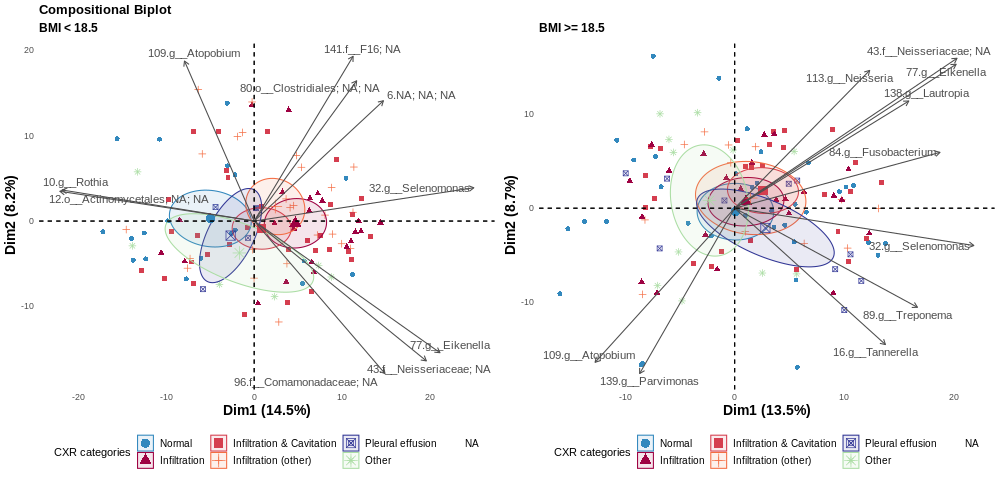

In [20]:
%%R -w 1000
# Extract genus names
# --------------------
genus_name <- data.frame(tax_table(asv16s_bacteria_genus_counts_ps)[colnames(asv16s_bacteria_genus_counts_clr),
                                                                    "Genus"], 
                         stringsAsFactors=FALSE)
# Some will be NAs, we add a renamed version that includes the family names or above rank if NA
genus_name$label <- unlist(lapply(as.character(rownames(genus_name)), 
                                         function(x){
                                             genus_name <- tax_table(asv16s_bacteria_genus_counts_ps)[x,"Genus"]; 
                                             family_name <- tax_table(asv16s_bacteria_genus_counts_ps)[x,"Family"]; 
                                             order_name <- tax_table(asv16s_bacteria_genus_counts_ps)[x,"Order"];
                                             if(is.na(genus_name) && is.na(family_name)){
                                                 paste(order_name,"NA; NA", sep='; ')
                                             }else if(is.na(genus_name)){
                                                 paste(family_name,"NA", sep='; ')
                                             }else{
                                                 genus_name
                                             }}))
genus_name$label <- paste(seq(1,dim(genus_name)[1]), genus_name$label, sep='.')


# PCA on each group of samples
asv16s_sample_metadata_blw18_clr_pca <- prcomp(asv16s_bacteria_genus_counts_clr[rownames(asv16s_sample_metadata_blw18),], 
                                               center=TRUE, scale=FALSE)
asv16s_sample_metadata_abv18_clr_pca <- prcomp(asv16s_bacteria_genus_counts_clr[rownames(asv16s_sample_metadata_abv18),], 
                                               center=TRUE, scale=FALSE)

rownames(asv16s_sample_metadata_blw18_clr_pca$rotation) <- genus_name[colnames(asv16s_bacteria_genus_counts_clr),
                                                                      "label"]
rownames(asv16s_sample_metadata_abv18_clr_pca$rotation) <- genus_name[colnames(asv16s_bacteria_genus_counts_clr),
                                                                      "label"]
# Biplots
asv16s_bactGenera_blw18_pca_biplot <- fviz_pca_biplot(asv16s_sample_metadata_blw18_clr_pca, 
                                                      pointsize = 2, 
                                                      label="var",
                                                      select.var=list(cos2=10),
                                                      habillage=asv16s_sample_metadata_blw18$cxr_categories, 
                                                      addEllipses=TRUE, 
                                                      ellipse.level=0.95,
                                                      repel=TRUE, 
                                                      ellipse.type="confidence", 
                                                      col.var="#4d4d4d",
                                                      jitter=list("point",0.2,0.2),
                                                      palette=c("#3288bd","#9e0142","#d53e4f","#f46d43","#313695","#abdda4"), 
                                                      legend.title="CXR categories", 
                                                      title="Compositional Biplot", 
                                                      subtitle="BMI < 18.5") + 
                                      theme_minimal() + 
                                      theme(axis.title=element_text(size=14,face="bold"), 
                                            plot.title = element_text(face="bold", hjust=0,size=13),
                                            plot.subtitle = element_text(face="bold", hjust=0,size=12),
                                            panel.grid.major = element_blank(), 
                                            panel.grid.minor = element_blank(), 
                                            legend.text=element_text(size=10),
                                            legend.position="bottom")

asv16s_bactGenera_abv18_pca_biplot <- fviz_pca_biplot(asv16s_sample_metadata_abv18_clr_pca, 
                                                      pointsize = 2, 
                                                      label="var",
                                                      select.var=list(cos2=10),
                                                      habillage=asv16s_sample_metadata_abv18$cxr_categories, 
                                                      addEllipses=TRUE, 
                                                      ellipse.level=0.95,
                                                      repel=TRUE, 
                                                      ellipse.type="confidence", 
                                                      col.var="#4d4d4d",
                                                      jitter=list("point",0.2,0.2),
                                                      palette=c("#3288bd","#9e0142","#d53e4f","#f46d43","#313695","#abdda4"), 
                                                      legend.title="CXR categories", 
                                                      title="",
                                                      subtitle="BMI >= 18.5") + 
                                      theme_minimal() + 
                                      theme(axis.title=element_text(size=14,face="bold"), 
                                            plot.title = element_text(face="bold", hjust=0,size=13),
                                            plot.subtitle = element_text(face="bold", hjust=0,size=12),
                                            panel.grid.major = element_blank(), 
                                            panel.grid.minor = element_blank(), 
                                            legend.text=element_text(size=10),
                                            legend.position="bottom")

grid.arrange(asv16s_bactGenera_blw18_pca_biplot,
             asv16s_bactGenera_abv18_pca_biplot, nrow=1)

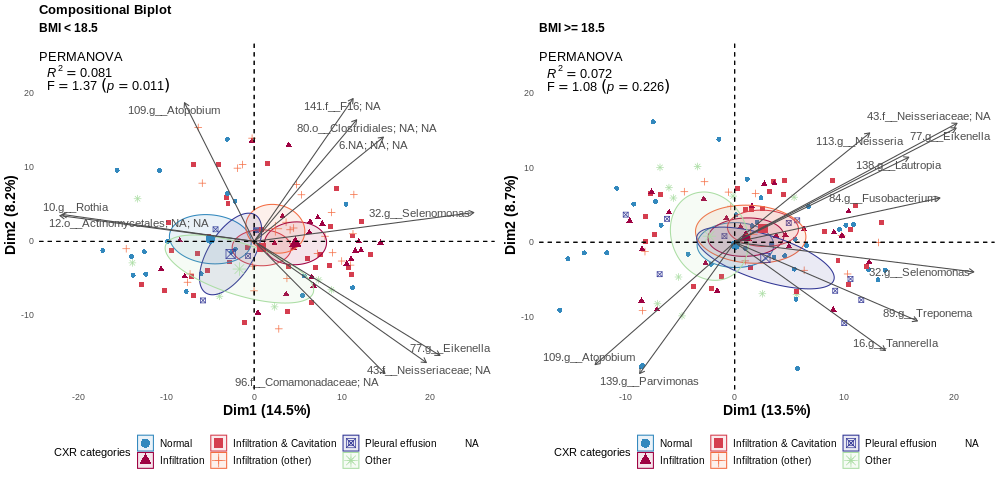

In [21]:
%%R -w 1000
blv18_adonis_adj_annotation <- c(c("PERMANOVA"),
                                 paste0("~~italic(R)^2 ==", round(asv_16s_bmi_blw18_adonis$R[1],3)),
                                 paste0("~~F ==", round(asv_16s_bmi_blw18_adonis$F[1],2), 
                                 "~(italic(p)== ", round(asv_16s_bmi_blw18_adonis[1,5],4),")"))

abv18_adonis_adj_annotation <- c(c("PERMANOVA"), 
                                 paste0("~~italic(R)^2 ==", round(asv_16s_bmi_abv18_adonis$R[1],3)),
                                 paste0("~~F ==", round(asv_16s_bmi_abv18_adonis$F[1],2), 
                                 "~(italic(p)== ", round(asv_16s_bmi_abv18_adonis[1,5],4),")"))

asv16s_bactGenera_blw18_pca_biplot <- asv16s_bactGenera_blw18_pca_biplot + 
                                        annotate("text", label=blv18_adonis_adj_annotation, 
                                                 x=-Inf, y=c(25,23,21), size=4.5, hjust=0, parse=TRUE)

asv16s_bactGenera_abv18_pca_biplot <- asv16s_bactGenera_abv18_pca_biplot + 
                                        annotate("text", label=abv18_adonis_adj_annotation, 
                                                 x=-Inf, y=c(25,23,21), size=4.5, hjust=0, parse=TRUE)

grid.arrange(asv16s_bactGenera_blw18_pca_biplot,
             asv16s_bactGenera_abv18_pca_biplot, nrow=1)


### 3.2 Assess associations between log-ratio abundances of interacting genera and chest X-ray findings

**Extract log-ratio abundances**

In [22]:
%%R
streptococcus_id <- rownames(genus_name)[which(genus_name$Genus == "g__Streptococcus")]
neisseria_id <- rownames(genus_name)[which(genus_name$Genus == "g__Neisseria")]
selenomonas_id <- rownames(genus_name)[which(genus_name$Genus == "g__Selenomonas")]
fusobacterium_id <- rownames(genus_name)[which(genus_name$Genus == "g__Fusobacterium")]

log_strepto_to_seleno_ratio <- as.vector(asv16s_bacteria_genus_counts_clr[,streptococcus_id] - 
                                         asv16s_bacteria_genus_counts_clr[,selenomonas_id])

log_strepto_to_fusoba_ratio <- as.vector(asv16s_bacteria_genus_counts_clr[,streptococcus_id] - 
                                         asv16s_bacteria_genus_counts_clr[,fusobacterium_id])

**Test normality of log-ratio abundances**


Testing normality of Streptococcus-to-Selenomonas log-ratio:

	Shapiro-Wilk normality test

data:  log_strepto_to_seleno_ratio
W = 0.97106, p-value = 7.706e-06


Testing normality of Streptococcus-to-Fusobacterium log-ratio:

	Shapiro-Wilk normality test

data:  log_strepto_to_fusoba_ratio
W = 0.97959, p-value = 0.0002306

[1] 22  7


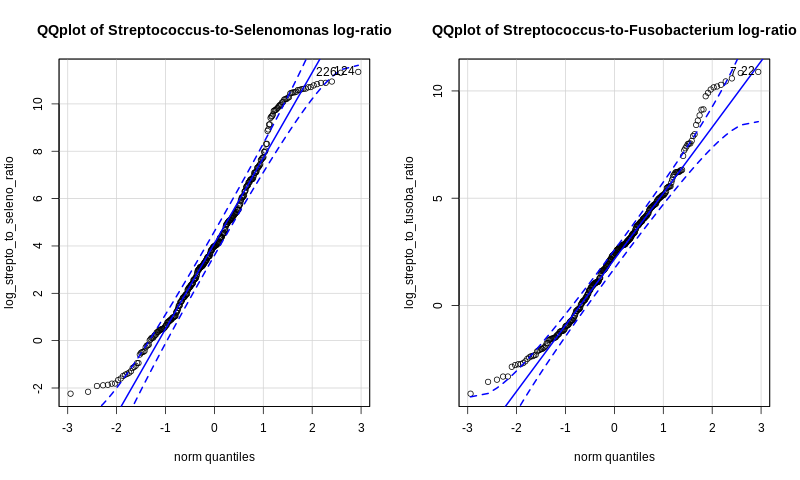

In [23]:
%%R -w 800
cat(crayon::bold("\nTesting normality of Streptococcus-to-Selenomonas log-ratio:\n"))
print(shapiro.test(log_strepto_to_seleno_ratio))

cat(crayon::bold("\nTesting normality of Streptococcus-to-Fusobacterium log-ratio:\n"))
print(shapiro.test(log_strepto_to_fusoba_ratio))

par(mfrow=c(1,2))
car::qqPlot(log_strepto_to_seleno_ratio, main="QQplot of Streptococcus-to-Selenomonas log-ratio")
car::qqPlot(log_strepto_to_fusoba_ratio, main="QQplot of Streptococcus-to-Fusobacterium log-ratio")

**Assessment of associations by PERMANOVA on one response variable**

As stated in Anderson 2017, "Furthermore, PERMANOVA on one response variable using Euclidean distance yields the classical univariate F statistic. So, PERMANOVA can also be used to do univariate ANOVA, but where p values are obtained by permutation, thus avoiding the assumption of normality."

To assess associations between the log-ratio abundances of interacting genera and CXR findings, we applied PERMANOVA on the log-ratio abundances.

<ins>PERMANOVA on _Streptococcus_-to-_Selenomonas_ log-ratio abundances</ins>

In [24]:
%%R
log_strepto_to_seleno_ratio_foradonis <- as.vector(asv16s_bacteria_genus_counts_clr[rownames(asv16s_sample_metadata_for_rda),
                                                                                    streptococcus_id] - 
                                                   asv16s_bacteria_genus_counts_clr[rownames(asv16s_sample_metadata_for_rda),
                                                                                    selenomonas_id])

cat(crayon::bold("\nPERMANOVA on Streptococcus-to-Selenomonas log-ratio:\n"))
log_strepto_to_seleno_ratio_adonis <- adonis2(log_strepto_to_seleno_ratio_foradonis ~ 
                                              cxr_categories + smear_grading_bin + tbdelay + delaymed_3cat +
                                              age_cat + male + bmi_cat + anemia_bin + 
                                              hiv + viral + bacterial + helminth + smoking + alcoholabuse + 
                                              season + seq_run + seq_depth_sc + 
                                              cxr_categories*bmi_cat, 
                                              data=asv16s_sample_metadata_for_rda, 
                                              method = "euclidean", by="margin", 
                                              contr.unordered = "contr.sum",contr.ordered="contr.poly", 
                                              parallel=7, permutations=how(nperm=9999))
print(log_strepto_to_seleno_ratio_adonis)
log_strepto_to_seleno_ratio_adonis_RsquareAdj <- permanova.RsquareAdj(log_strepto_to_seleno_ratio_adonis)
cat("\nR2Adj: ", log_strepto_to_seleno_ratio_adonis_RsquareAdj)

cat(crayon::bold("\nis the model better than the null model:\n"))
log_strepto_to_seleno_ratio_adonis_overall  <- adonis2(log_strepto_to_seleno_ratio_foradonis ~ 
                                                       cxr_categories + smear_grading_bin + tbdelay + delaymed_3cat +
                                                       age_cat + male + bmi_cat + anemia_bin + 
                                                       hiv + viral + bacterial + helminth + smoking + alcoholabuse + 
                                                       season + seq_run + seq_depth_sc + 
                                                       cxr_categories*bmi_cat, 
                                                       data=asv16s_sample_metadata_for_rda, 
                                                       method = "euclidean", by=NULL, 
                                                       contr.unordered = "contr.sum",contr.ordered="contr.poly", 
                                                       parallel=7, permutations=how(nperm=9999))
print(log_strepto_to_seleno_ratio_adonis_overall)



PERMANOVA on Streptococcus-to-Selenomonas log-ratio:
Permutation test for adonis under reduced model
Marginal effects of terms
Permutation: free
Number of permutations: 9999

adonis2(formula = log_strepto_to_seleno_ratio_foradonis ~ cxr_categories + smear_grading_bin + tbdelay + delaymed_3cat + age_cat + male + bmi_cat + anemia_bin + hiv + viral + bacterial + helminth + smoking + alcoholabuse + season + seq_run + seq_depth_sc + cxr_categories * bmi_cat, data = asv16s_sample_metadata_for_rda, permutations = how(nperm = 9999), method = "euclidean", by = "margin", parallel = 7, contr.unordered = "contr.sum", contr.ordered = "contr.poly")
                        Df SumOfSqs      R2      F Pr(>F)   
smear_grading_bin        1    19.23 0.01019 1.6639 0.1949   
tbdelay                  1     1.47 0.00078 0.1272 0.7193   
delaymed_3cat            2    10.64 0.00564 0.4605 0.6469   
age_cat                  3    21.42 0.01135 0.6179 0.5970   
male                     1    15.54 0.00824 1.3450 

In [25]:
%%R
cat(crayon::bold("\nis the model with only significant terms better than the null model:\n"))
log_strepto_to_seleno_ratio_adonis_sig_overall  <- adonis2(log_strepto_to_seleno_ratio_foradonis ~ 
                                                           cxr_categories*bmi_cat, 
                                                           data=asv16s_sample_metadata_for_rda, 
                                                           method = "euclidean",by=NULL, 
                                                           contr.unordered = "contr.sum",contr.ordered="contr.poly", 
                                                       parallel=7, permutations=how(nperm=9999))
print(log_strepto_to_seleno_ratio_adonis_sig_overall)

log_strepto_to_seleno_ratio_adonis_sig_overall_r2adj <- permanova.RsquareAdj(log_strepto_to_seleno_ratio_adonis_sig_overall)

cat("\nR2Adj: ", log_strepto_to_seleno_ratio_adonis_sig_overall_r2adj)


is the model with only significant terms better than the null model:
Permutation test for adonis under reduced model
Permutation: free
Number of permutations: 9999

adonis2(formula = log_strepto_to_seleno_ratio_foradonis ~ cxr_categories * bmi_cat, data = asv16s_sample_metadata_for_rda, permutations = how(nperm = 9999), method = "euclidean", by = NULL, parallel = 7, contr.unordered = "contr.sum", contr.ordered = "contr.poly")
          Df SumOfSqs      R2     F Pr(>F)  
Model     11   283.01 0.14999 2.294 0.0104 *
Residual 143  1603.80 0.85001               
Total    154  1886.81 1.00000               
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R2Adj:  0.08414791

<ins>PERMANOVA on _Streptococcus_-to-_Fusobacterium_ log-ratio abundances</ins>

In [26]:
%%R
log_strepto_to_fusoba_ratio_foradonis <- as.vector(asv16s_bacteria_genus_counts_clr[rownames(asv16s_sample_metadata_for_rda),
                                                                                    streptococcus_id] - 
                                                   asv16s_bacteria_genus_counts_clr[rownames(asv16s_sample_metadata_for_rda),
                                                                                    fusobacterium_id])
cat(crayon::bold("\nPERMANOVA on Streptococcus-to-Fusobacterium log-ratio:\n"))
log_strepto_to_fusoba_ratio_adonis <- adonis2(log_strepto_to_fusoba_ratio_foradonis ~ 
                                              cxr_categories + smear_grading_bin + tbdelay + delaymed_3cat +
                                              age_cat + male + bmi_cat + anemia_bin + 
                                              hiv + viral + bacterial + helminth + smoking + alcoholabuse + 
                                              season + seq_run + seq_depth_sc + 
                                              cxr_categories*bmi_cat, 
                                              data=asv16s_sample_metadata_for_rda, 
                                              method = "euclidean", by="margin", 
                                              contr.unordered = "contr.sum",contr.ordered="contr.poly", 
                                              parallel=7, permutations=how(nperm=9999))
log_strepto_to_fusoba_ratio_adonis_RsquareAdj <- permanova.RsquareAdj(log_strepto_to_fusoba_ratio_adonis)

print(log_strepto_to_fusoba_ratio_adonis)
cat("\nR2Adj: ", log_strepto_to_fusoba_ratio_adonis_RsquareAdj,"\n")

cat(crayon::bold("\nis the model better than the null model:\n"))
log_strepto_to_fusoba_ratio_adonis_overall <- adonis2(log_strepto_to_fusoba_ratio_foradonis ~ 
                                                      cxr_categories + smear_grading_bin + tbdelay + delaymed_3cat +
                                                      age_cat + male + bmi_cat + anemia_bin + 
                                                      hiv + viral + bacterial + helminth + smoking + alcoholabuse + 
                                                      season + seq_run + seq_depth_sc + 
                                                      cxr_categories*bmi_cat, 
                                                      data=asv16s_sample_metadata_for_rda, 
                                                      method = "euclidean", by=NULL, 
                                                      contr.unordered = "contr.sum",contr.ordered="contr.poly", 
                                                      parallel=7, permutations=how(nperm=9999))
print(log_strepto_to_fusoba_ratio_adonis_overall)


PERMANOVA on Streptococcus-to-Fusobacterium log-ratio:
Permutation test for adonis under reduced model
Marginal effects of terms
Permutation: free
Number of permutations: 9999

adonis2(formula = log_strepto_to_fusoba_ratio_foradonis ~ cxr_categories + smear_grading_bin + tbdelay + delaymed_3cat + age_cat + male + bmi_cat + anemia_bin + hiv + viral + bacterial + helminth + smoking + alcoholabuse + season + seq_run + seq_depth_sc + cxr_categories * bmi_cat, data = asv16s_sample_metadata_for_rda, permutations = how(nperm = 9999), method = "euclidean", by = "margin", parallel = 7, contr.unordered = "contr.sum", contr.ordered = "contr.poly")
                        Df SumOfSqs      R2      F Pr(>F)   
smear_grading_bin        1     1.48 0.00098 0.1652 0.6771   
tbdelay                  1     1.76 0.00116 0.1964 0.6579   
delaymed_3cat            2     4.79 0.00316 0.2673 0.7686   
age_cat                  3    17.66 0.01164 0.6569 0.5877   
male                     1     0.17 0.00011 0.018

In [27]:
%%R
cat(crayon::bold("\nis the model with only significant terms better than the null model:\n"))
log_strepto_to_fusoba_ratio_adonis_sig_overall  <- adonis2(log_strepto_to_fusoba_ratio_foradonis ~ 
                                                           cxr_categories*bmi_cat, 
                                                           data=asv16s_sample_metadata_for_rda, 
                                                           method = "euclidean",by=NULL, 
                                                           contr.unordered = "contr.sum",contr.ordered="contr.poly", 
                                                       parallel=7, permutations=how(nperm=9999))
print(log_strepto_to_fusoba_ratio_adonis_sig_overall)

log_strepto_to_fusoba_ratio_adonis_sig_overall_r2adj <- permanova.RsquareAdj(log_strepto_to_fusoba_ratio_adonis_sig_overall)

cat("\nR2Adj: ", log_strepto_to_fusoba_ratio_adonis_sig_overall_r2adj)


is the model with only significant terms better than the null model:
Permutation test for adonis under reduced model
Permutation: free
Number of permutations: 9999

adonis2(formula = log_strepto_to_fusoba_ratio_foradonis ~ cxr_categories * bmi_cat, data = asv16s_sample_metadata_for_rda, permutations = how(nperm = 9999), method = "euclidean", by = NULL, parallel = 7, contr.unordered = "contr.sum", contr.ordered = "contr.poly")
          Df SumOfSqs      R2      F Pr(>F)   
Model     11   266.97 0.17591 2.7749 0.0024 **
Residual 143  1250.73 0.82409                 
Total    154  1517.71 1.00000                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R2Adj:  0.1120674

**Effect sizes of factors within PERMANOVA model on Streptococcus-to-Selenomonas log-ratio:**

In [28]:
%%R
# Adapted from http://www.understandingdata.net/2017/05/11/anova-tables-in-r/
# Calculates the partial eta-squared as a measure of effect size of each term in an Anova model
# anova.obj: output from function Anova in the car package
permanova.effectsize <- function(adonis.obj){
    adonis.obj$pes <- c(adonis.obj$'SumOfSqs'[-c(nrow(adonis.obj),nrow(adonis.obj)-1)], 
                        NA,NA)/(adonis.obj$'SumOfSqs' + adonis.obj$'SumOfSqs'[nrow(adonis.obj)-1])
    return(adonis.obj)
}

log_strepto_to_seleno_ratio_adonis_w_pes <- permanova.effectsize(log_strepto_to_seleno_ratio_adonis)
log_strepto_to_seleno_ratio_adonis_w_pes

Permutation test for adonis under reduced model
Marginal effects of terms
Permutation: free
Number of permutations: 9999

adonis2(formula = log_strepto_to_seleno_ratio_foradonis ~ cxr_categories + smear_grading_bin + tbdelay + delaymed_3cat + age_cat + male + bmi_cat + anemia_bin + hiv + viral + bacterial + helminth + smoking + alcoholabuse + season + seq_run + seq_depth_sc + cxr_categories * bmi_cat, data = asv16s_sample_metadata_for_rda, permutations = how(nperm = 9999), method = "euclidean", by = "margin", parallel = 7, contr.unordered = "contr.sum", contr.ordered = "contr.poly")
                        Df SumOfSqs      R2      F Pr(>F)      pes
smear_grading_bin        1    19.23 0.01019 1.6639 0.1949 0.013347
tbdelay                  1     1.47 0.00078 0.1272 0.7193 0.001033
delaymed_3cat            2    10.64 0.00564 0.4605 0.6469 0.007431
age_cat                  3    21.42 0.01135 0.6179 0.5970 0.014846
male                     1    15.54 0.00824 1.3450 0.2549 0.010817
anemia_b

Lets visualize the effect sizes:

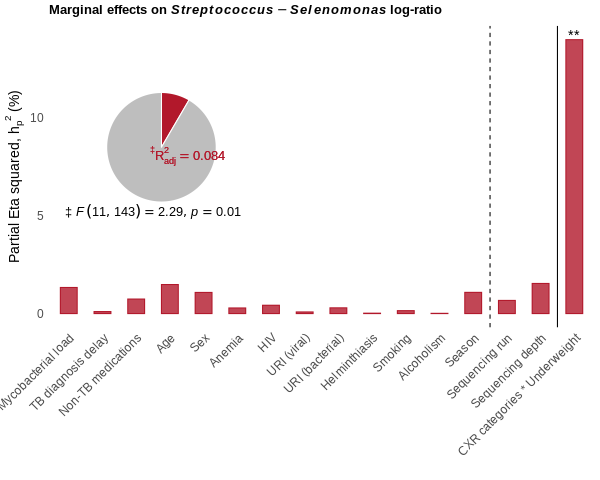

In [29]:
%%R -w 600
log_strepto_to_seleno_ratio_adonis_w_pes_toplot<- log_strepto_to_seleno_ratio_adonis_w_pes[-c(nrow(log_strepto_to_seleno_ratio_adonis_w_pes),
                                                                                              nrow(log_strepto_to_seleno_ratio_adonis_w_pes)-1),]
log_strepto_to_seleno_ratio_adonis_w_pes_toplot <- as.data.frame(log_strepto_to_seleno_ratio_adonis_w_pes_toplot)
log_strepto_to_seleno_ratio_adonis_w_pes_toplot$Row.names <- factor(rownames(log_strepto_to_seleno_ratio_adonis_w_pes_toplot), 
                                                                    levels=rownames(log_strepto_to_seleno_ratio_adonis_w_pes_toplot), 
                                                                    labels=rownames(log_strepto_to_seleno_ratio_adonis_w_pes_toplot))
# To rename labels
var_labels <- c('smear_grading_bin'='Mycobacterial load',
                'tbdelay'='TB diagnosis delay',
                'delaymed_3cat'='Non-TB medications', 
                'age_cat'='Age',
                'male'='Sex',
                'anemia_bin'='Anemia', 
                'hiv'='HIV',
                'viral'='URI (viral)', 
                'bacterial'='URI (bacterial)', 
                'helminth'='Helminthiasis', 
                'smoking'='Smoking',
                'alcoholabuse'='Alcoholism',
                'season'='Season', 
                'seq_run'='Sequencing run', 
                'seq_depth_sc'='Sequencing depth',
                'cxr_categories:bmi_cat'='CXR categories * Underweight')

# Annotations for p-values
signif_marks <- rep("",length(var_labels))
signif_marks[ log_strepto_to_seleno_ratio_adonis_w_pes_toplot[,'Pr(>F)'] < 0.001 ] <- '***'
signif_marks[ log_strepto_to_seleno_ratio_adonis_w_pes_toplot[,'Pr(>F)'] < 0.01 & log_strepto_to_seleno_ratio_adonis_w_pes_toplot[,'Pr(>F)'] >= 0.001 ] <- '**'
signif_marks[ log_strepto_to_seleno_ratio_adonis_w_pes_toplot[,'Pr(>F)'] < 0.05 & log_strepto_to_seleno_ratio_adonis_w_pes_toplot[,'Pr(>F)'] >= 0.01 ] <- '*'

log_strepto_to_seleno_ratio_adonis_pes_plot <- ggplot(log_strepto_to_seleno_ratio_adonis_w_pes_toplot, 
                                                      aes(x=Row.names,y=pes*100)) + 
                                               geom_bar(position='identity', stat='identity',
                                                       fill="#b2182b", color="#b2182b", alpha=0.8, width=0.5) + 
                                               theme_minimal() + 
                                               theme(axis.text.x = element_text(size=12,angle=45, hjust=1), 
                                                     axis.text.y = element_text(size=12),
                                                     axis.title=element_text(size=14,face="bold"), 
                                                     plot.title = element_text(face="bold", hjust=0,size=13),
                                                     panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
                                               scale_x_discrete(labels=var_labels) + 
                                               labs(x='', y=bquote('Partial Eta squared,' ~ {h[p]}^2 ~ '(%)'), 
                                                    title=expression(bold('Marginal effects on'~bolditalic(Streptococcus-Selenomonas)~'log-ratio'))) + 
                                               geom_text(aes(label=signif_marks), size=5, vjust=0) + 
                                               geom_vline(xintercept=c(13.5,15.5), linetype = c("dashed","solid"))

log_strepto_to_seleno_ratio_adonis_pie_data <- data.frame(Radj=c(log_strepto_to_seleno_ratio_adonis_sig_overall_r2adj, 
                                                                 (1-log_strepto_to_seleno_ratio_adonis_sig_overall_r2adj)), 
                                                          group=c('Radj','FVU'))

log_strepto_to_seleno_ratio_adonis_pie_label <- bquote(""^.("\u2021")*R[adj]^2 == .(signif(log_strepto_to_seleno_ratio_adonis_pie_data$Radj[1], 2)))

log_strepto_to_seleno_ratio_adonis_pie <- ggplot(log_strepto_to_seleno_ratio_adonis_pie_data, 
                                                 aes(x="",y=Radj, fill=group)) + 
                                          geom_bar(stat="identity", width=1, color="white") + 
                                          coord_polar("y", start=0) +
                                          scale_fill_manual(values = c("grey","#b2182b")) + 
                                          theme_void() + theme(legend.position="none") + 
                                          geom_text(aes(y=0.3, size=4.5,label=deparse(log_strepto_to_seleno_ratio_adonis_pie_label)), 
                                                    color="#b2182b", parse=TRUE)

log_strepto_to_seleno_ratio_adonis_pie_grob <- ggplotGrob(log_strepto_to_seleno_ratio_adonis_pie)

log_strepto_to_seleno_ratio_adonis_fstats_label <- paste0('list("\u2021"~italic(F)(',
                                                          log_strepto_to_seleno_ratio_adonis_sig_overall["Model","Df"], ',', 
                                                          log_strepto_to_seleno_ratio_adonis_sig_overall["Residual","Df"], ') == ', 
                                                          signif(log_strepto_to_seleno_ratio_adonis_sig_overall["Model","F"],3), 
                                                          ' , italic(p) == ',
                                                          signif(log_strepto_to_seleno_ratio_adonis_sig_overall["Model","Pr(>F)"], 2), ')')

log_strepto_to_seleno_ratio_adonis_pes_plot_pie <- log_strepto_to_seleno_ratio_adonis_pes_plot + 
                                                    annotate('text', x=3.5, y=5.2, size=4.5,
                                                             label=log_strepto_to_seleno_ratio_adonis_fstats_label, 
                                                             parse=TRUE) + 
                                                    annotation_custom(grob=log_strepto_to_seleno_ratio_adonis_pie_grob, 
                                                                      xmin=0.5, xmax=7, ymin=5, ymax=12)

plot(log_strepto_to_seleno_ratio_adonis_pes_plot_pie)

**Effect sizes of factors within PERMANOVA model on Streptococcus-to-Fusobacterium log-ratio:**

In [30]:
%%R

log_strepto_to_fusoba_ratio_adonis_w_pes <- permanova.effectsize(log_strepto_to_fusoba_ratio_adonis)
log_strepto_to_fusoba_ratio_adonis_w_pes

Permutation test for adonis under reduced model
Marginal effects of terms
Permutation: free
Number of permutations: 9999

adonis2(formula = log_strepto_to_fusoba_ratio_foradonis ~ cxr_categories + smear_grading_bin + tbdelay + delaymed_3cat + age_cat + male + bmi_cat + anemia_bin + hiv + viral + bacterial + helminth + smoking + alcoholabuse + season + seq_run + seq_depth_sc + cxr_categories * bmi_cat, data = asv16s_sample_metadata_for_rda, permutations = how(nperm = 9999), method = "euclidean", by = "margin", parallel = 7, contr.unordered = "contr.sum", contr.ordered = "contr.poly")
                        Df SumOfSqs      R2      F Pr(>F)      pes
smear_grading_bin        1     1.48 0.00098 0.1652 0.6771 0.001341
tbdelay                  1     1.76 0.00116 0.1964 0.6579 0.001594
delaymed_3cat            2     4.79 0.00316 0.2673 0.7686 0.004328
age_cat                  3    17.66 0.01164 0.6569 0.5877 0.015770
male                     1     0.17 0.00011 0.0187 0.8893 0.000152
anemia_b

Lets visualize the effect sizes:

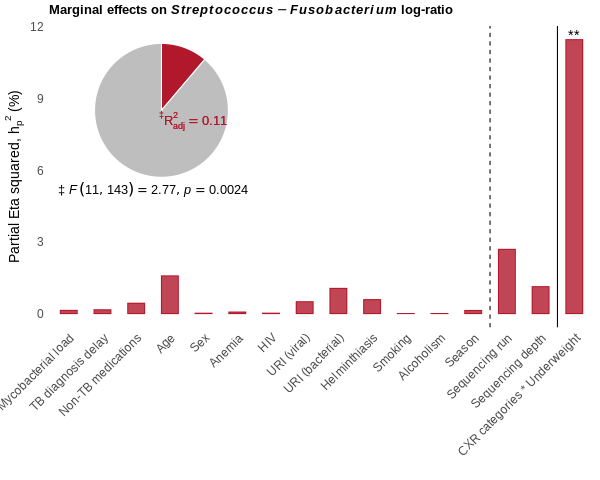

In [31]:
%%R -w 600
log_strepto_to_fusoba_ratio_adonis_w_pes_toplot<- log_strepto_to_fusoba_ratio_adonis_w_pes[-c(nrow(log_strepto_to_fusoba_ratio_adonis_w_pes),
                                                                                              nrow(log_strepto_to_fusoba_ratio_adonis_w_pes)-1),]
log_strepto_to_fusoba_ratio_adonis_w_pes_toplot <- as.data.frame(log_strepto_to_fusoba_ratio_adonis_w_pes_toplot)
log_strepto_to_fusoba_ratio_adonis_w_pes_toplot$Row.names <- factor(rownames(log_strepto_to_fusoba_ratio_adonis_w_pes_toplot), 
                                                                    levels=rownames(log_strepto_to_fusoba_ratio_adonis_w_pes_toplot), 
                                                                    labels=rownames(log_strepto_to_fusoba_ratio_adonis_w_pes_toplot))
# To rename labels
var_labels <- c('smear_grading_bin'='Mycobacterial load',
                'tbdelay'='TB diagnosis delay',
                'delaymed_3cat'='Non-TB medications', 
                'age_cat'='Age',
                'male'='Sex',
                'anemia_bin'='Anemia', 
                'hiv'='HIV',
                'viral'='URI (viral)', 
                'bacterial'='URI (bacterial)', 
                'helminth'='Helminthiasis', 
                'smoking'='Smoking',
                'alcoholabuse'='Alcoholism',
                'season'='Season', 
                'seq_run'='Sequencing run', 
                'seq_depth_sc'='Sequencing depth',
                'cxr_categories:bmi_cat'='CXR categories * Underweight')

# Annotations for p-values
signif_marks <- rep("",length(var_labels))
signif_marks[ log_strepto_to_fusoba_ratio_adonis_w_pes_toplot[,'Pr(>F)'] < 0.001 ] <- '***'
signif_marks[ log_strepto_to_fusoba_ratio_adonis_w_pes_toplot[,'Pr(>F)'] < 0.01 & log_strepto_to_fusoba_ratio_adonis_w_pes_toplot[,'Pr(>F)'] >= 0.001 ] <- '**'
signif_marks[ log_strepto_to_fusoba_ratio_adonis_w_pes_toplot[,'Pr(>F)'] < 0.05 & log_strepto_to_fusoba_ratio_adonis_w_pes_toplot[,'Pr(>F)'] >= 0.01 ] <- '*'

log_strepto_to_fusoba_ratio_adonis_pes_plot <- ggplot(log_strepto_to_fusoba_ratio_adonis_w_pes_toplot, 
                                                      aes(x=Row.names,y=pes*100)) + 
                                               geom_bar(position='identity', stat='identity',
                                                       fill="#b2182b", color="#b2182b", alpha=0.8, width=0.5) + 
                                               theme_minimal() + 
                                               theme(axis.text.x = element_text(size=12,angle=45, hjust=1), 
                                                     axis.text.y = element_text(size=12),
                                                     axis.title=element_text(size=14,face="bold"), 
                                                     plot.title = element_text(face="bold", hjust=0,size=13),
                                                     panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
                                               scale_x_discrete(labels=var_labels) + 
                                               labs(x='', y=bquote('Partial Eta squared,' ~ {h[p]}^2 ~ '(%)'), 
                                                    title=expression(bold('Marginal effects on'~bolditalic(Streptococcus-Fusobacterium)~'log-ratio'))) + 
                                               geom_text(aes(label=signif_marks), size=5, vjust=0) + 
                                               geom_vline(xintercept=c(13.5,15.5), linetype = c("dashed","solid"))

log_strepto_to_fusoba_ratio_adonis_pie_data <- data.frame(Radj=c(log_strepto_to_fusoba_ratio_adonis_sig_overall_r2adj, 
                                                                 (1-log_strepto_to_fusoba_ratio_adonis_sig_overall_r2adj)), 
                                                          group=c('Radj','FVU'))

log_strepto_to_fusoba_ratio_adonis_pie_label <- bquote(""^.("\u2021")*R[adj]^2 == .(signif(log_strepto_to_fusoba_ratio_adonis_pie_data$Radj[1], 2)))

log_strepto_to_fusoba_ratio_adonis_pie <- ggplot(log_strepto_to_fusoba_ratio_adonis_pie_data, 
                                                 aes(x="",y=Radj, fill=group)) + 
                                          geom_bar(stat="identity", width=1, color="white") + 
                                          coord_polar("y", start=0) +
                                          scale_fill_manual(values = c("grey","#b2182b")) + 
                                          theme_void() + theme(legend.position="none") + 
                                          geom_text(aes(y=0.3, size=4.5,label=deparse(log_strepto_to_fusoba_ratio_adonis_pie_label)), 
                                                    color="#b2182b", parse=TRUE)

log_strepto_to_fusoba_ratio_adonis_pie_grob <- ggplotGrob(log_strepto_to_fusoba_ratio_adonis_pie)

log_strepto_to_fusoba_ratio_adonis_fstats_label <- paste0('list("\u2021"~italic(F)(',
                                                          log_strepto_to_fusoba_ratio_adonis_sig_overall["Model","Df"], ',', 
                                                          log_strepto_to_fusoba_ratio_adonis_sig_overall["Residual","Df"], ') == ', 
                                                          signif(log_strepto_to_fusoba_ratio_adonis_sig_overall["Model","F"],3), 
                                                          ' , italic(p) == ',
                                                          signif(log_strepto_to_fusoba_ratio_adonis_sig_overall["Model","Pr(>F)"], 2), ')')

log_strepto_to_fusoba_ratio_adonis_pes_plot_pie <- log_strepto_to_fusoba_ratio_adonis_pes_plot + 
                                                    annotate('text', x=3.5, y=5.2, size=4.5,
                                                             label=log_strepto_to_fusoba_ratio_adonis_fstats_label, 
                                                             parse=TRUE) + 
                                                    annotation_custom(grob=log_strepto_to_fusoba_ratio_adonis_pie_grob, 
                                                                      xmin=0.5, xmax=7, ymin=5, ymax=12)

plot(log_strepto_to_fusoba_ratio_adonis_pes_plot_pie)

**Test differences in means of _Streptococcus_-to-_Selenomonas_ log-ratios by CXR categories**

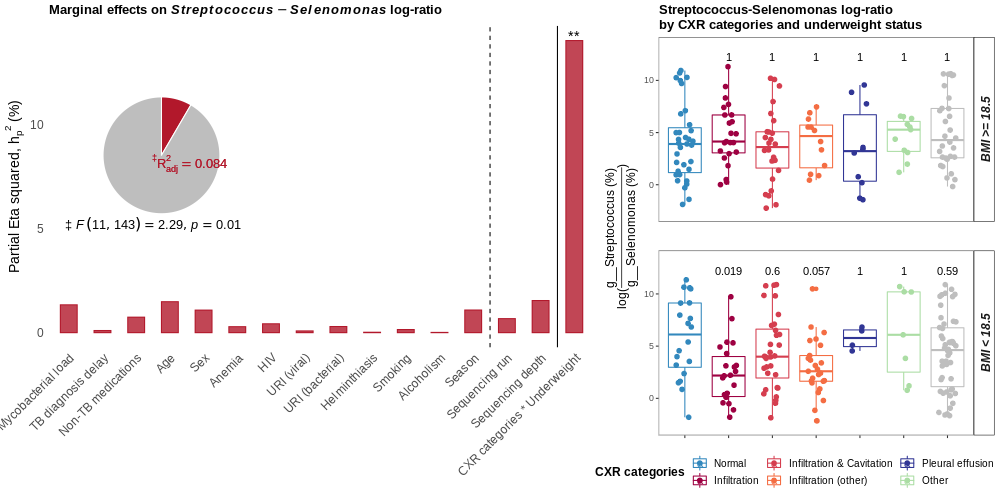

In [32]:
%%R -w 1000 -h 500 -u px
log_strepto_to_seleno_ratio <- as.vector(asv16s_bacteria_genus_counts_clr[,streptococcus_id] - 
                                         asv16s_bacteria_genus_counts_clr[,selenomonas_id])

log_strepto_to_fusoba_ratio <- as.vector(asv16s_bacteria_genus_counts_clr[,streptococcus_id] - 
                                         asv16s_bacteria_genus_counts_clr[,fusobacterium_id])

cxr_colors <- c("#3288bd","#9e0142","#d53e4f","#f46d43","#313695","#abdda4")
temp_label <- expression(paste("log(", frac("g__Streptococcus (%)","g__Selenomonas (%)"),")"))
strep_selen_and_cxr_bmi_boxplots <- ggplot(data=clinical_metadata_table[rownames(asv16s_bacteria_genus_counts_clr),], 
                                           aes(y=log_strepto_to_seleno_ratio, x=cxr_categories, colour=cxr_categories)) + 
                                    geom_boxplot() +
                                    geom_jitter(size=2, position=position_jitter(0.2)) + 
                                    facet_grid(factor(bmi_cat, levels=levels(bmi_cat), 
                                                      labels=c("BMI >= 18.5", "BMI < 18.5")) ~ .) +
                                    scale_colour_manual(name="CXR categories",
                                                        values=cxr_colors, na.value = "grey") + 
                                    scale_fill_manual(values=cxr_colors, na.value = "grey") + 
                                    stat_compare_means(aes(label= ..p.adj..), method = "wilcox.test", 
                                                       ref.group = "Normal", 
                                                       label.y = max(log_strepto_to_seleno_ratio)+0.5) +
                                    ylim(min(log_strepto_to_seleno_ratio)-0.5,max(log_strepto_to_seleno_ratio)+2) +
                                    labs(title="Streptococcus-Selenomonas log-ratio \nby CXR categories and underweight status", 
                                         x="CXR categories", y=temp_label) +
                                    theme_bw() + 
                                    theme(axis.text.x=element_blank(), 
                                          plot.title = element_text(face="bold", hjust=0,size=13),
                                          strip.text.y = element_text(angle = 90, vjust = 0, size=12, face = "bold.italic"),
                                          legend.title=element_text(face="bold",size=12),
                                          legend.position="bottom",
                                          axis.title=element_text(size=12), 
                                          axis.title.x=element_blank(),
                                          axis.line = element_line(colour = "grey80"),
                                          panel.spacing = unit(2, "lines"), 
                                          strip.background = element_rect(colour="black", fill="white"), 
                                          panel.grid.major = element_blank(),
                                          panel.grid.minor = element_blank(), 
                                          legend.text=element_text(size=10)) + 
                                    guides(fill=guide_legend(override.aes = list(size = 4)))

grid.arrange(log_strepto_to_seleno_ratio_adonis_pes_plot_pie, 
             strep_selen_and_cxr_bmi_boxplots, 
             widths=c(0.6,0.4))

**Test differences in means of _Streptococcus_-to-_Fusobacterium_ log-ratios by CXR categories**

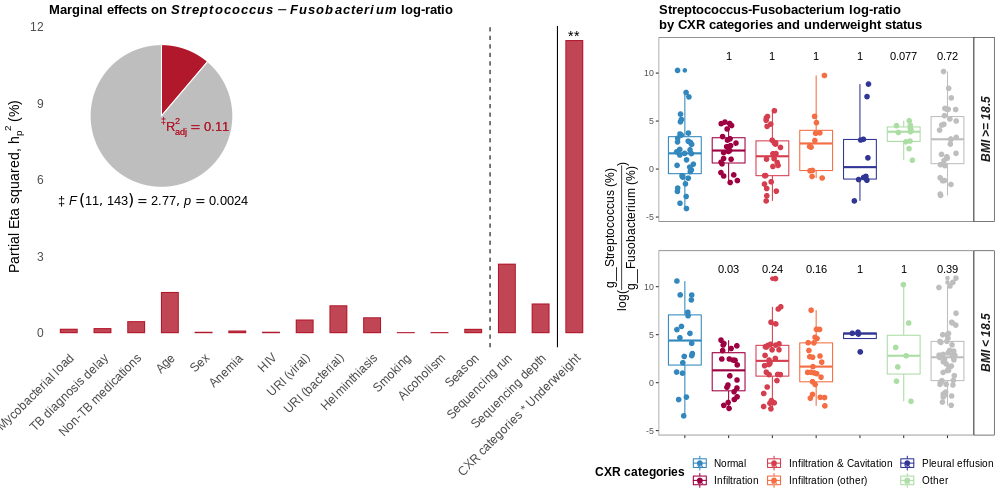

In [33]:
%%R -w 1000 -h 500 -u px

log_strepto_to_fusoba_ratio <- as.vector(asv16s_bacteria_genus_counts_clr[,streptococcus_id] - 
                                         asv16s_bacteria_genus_counts_clr[,fusobacterium_id])

cxr_colors <- c("#3288bd","#9e0142","#d53e4f","#f46d43","#313695","#abdda4")
temp_label_2 <- expression(paste("log(", frac("g__Streptococcus (%)","g__Fusobacterium (%)"),")"))
strep_fusob_and_cxr_bmi_boxplots <- ggplot(data=clinical_metadata_table[rownames(asv16s_bacteria_genus_counts_clr),], 
                                           aes(y=log_strepto_to_fusoba_ratio, x=cxr_categories, colour=cxr_categories)) + 
                                    geom_boxplot() +
                                    geom_jitter(size=2, position=position_jitter(0.2)) + 
                                    facet_grid(factor(bmi_cat, levels=levels(bmi_cat), 
                                                      labels=c("BMI >= 18.5", "BMI < 18.5")) ~ .) +
                                    scale_colour_manual(name="CXR categories",
                                                        values=cxr_colors, na.value = "grey") + 
                                    scale_fill_manual(values=cxr_colors, na.value = "grey") + 
                                    stat_compare_means(aes(label= ..p.adj..), method = "wilcox.test", 
                                                       ref.group = "Normal", 
                                                       label.y = max(log_strepto_to_fusoba_ratio)+0.5) +
                                    ylim(min(log_strepto_to_fusoba_ratio)-0.5,max(log_strepto_to_fusoba_ratio)+2) +
                                    labs(title="Streptococcus-Fusobacterium log-ratio \nby CXR categories and underweight status", 
                                         x="CXR categories", y=temp_label_2) +
                                    theme_bw() + 
                                    theme(axis.text.x=element_blank(), 
                                          plot.title = element_text(face="bold", hjust=0, size=13),
                                          strip.text.y = element_text(angle = 90, vjust = 0, size=12, face = "bold.italic"),
                                          legend.title=element_text(face="bold",size=12),
                                          legend.position="bottom",
                                          axis.title=element_text(size=12), 
                                          axis.title.x=element_blank(),
                                          axis.line = element_line(colour = "grey80"),
                                          panel.spacing = unit(2, "lines"), 
                                          strip.background = element_rect(colour="black", fill="white"), 
                                          panel.grid.major = element_blank(),
                                          panel.grid.minor = element_blank(), 
                                          legend.text=element_text(size=10)) + 
                                    guides(fill=guide_legend(override.aes = list(size = 4)))

grid.arrange(log_strepto_to_fusoba_ratio_adonis_pes_plot_pie, 
             strep_fusob_and_cxr_bmi_boxplots, 
             widths=c(0.6,0.4))

### 3.3 Panel of results

[1] 16.66667 20.83333


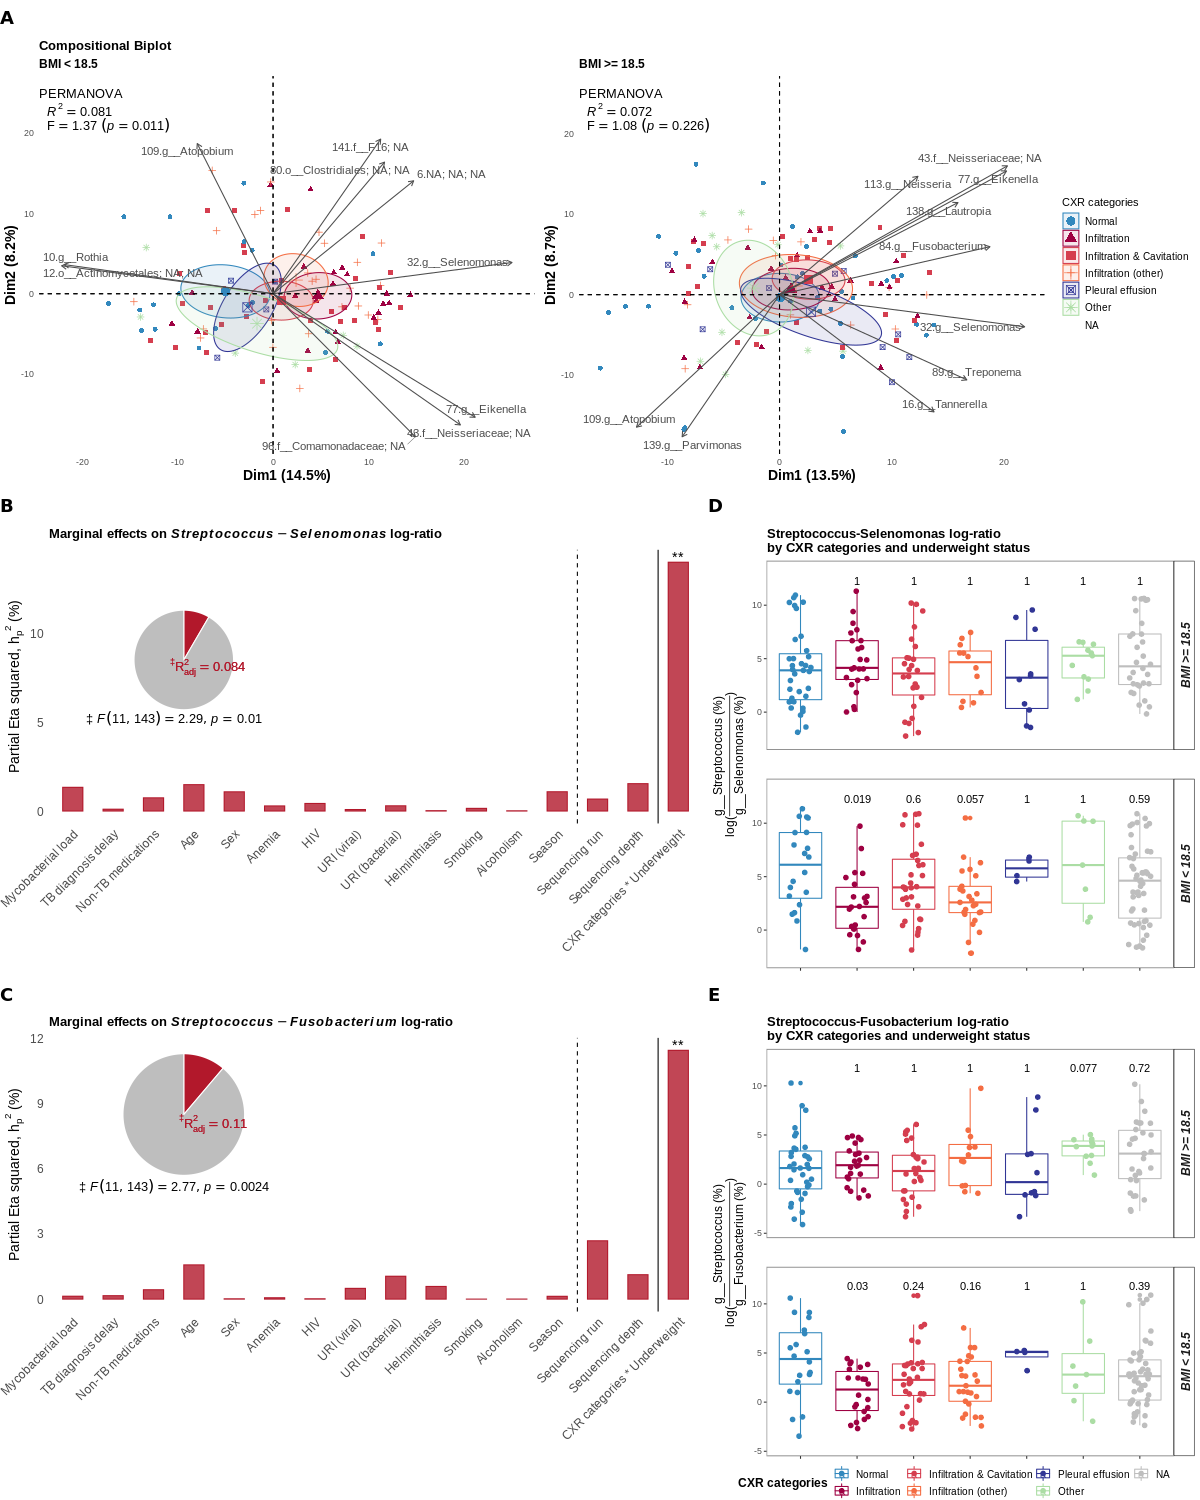

In [34]:
%%R -w 1200 -h 1500
print(par('din'))
panel_layout_matrix <- rbind(c(1,1,1,1,1,1),
                             c(2,2,2,3,3,3),
                             c(4,4,4,4,5,5),
                             c(6,6,6,6,7,7),
                             c(8,8,8,8,9,9),
                             c(10,10,10,10,11,11),
                             c(NA,NA,NA,NA,12,12))

biplot_legend <- cowplot::get_legend(asv16s_bactGenera_abv18_pca_biplot)
boxplots_legend <- cowplot::get_legend(strep_fusob_and_cxr_bmi_boxplots)
cxr_bmi_effect_on_interactions_panel <- grid.arrange(grobs=list(textGrob("A",just="left", x=unit(0, "npc"), 
                                                                         gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")), 
                                                                asv16s_bactGenera_blw18_pca_biplot + theme(legend.position="none"),
                                                                asv16s_bactGenera_abv18_pca_biplot + theme(legend.position="right"),
                                                                textGrob("B",just="left", x=unit(0, "npc"), 
                                                                         gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")), 
                                                                textGrob("D",just="left", x=unit(0, "npc"), 
                                                                         gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                                log_strepto_to_seleno_ratio_adonis_pes_plot_pie, 
                                                                strep_selen_and_cxr_bmi_boxplots + theme(legend.position="none"),
                                                                textGrob("C",just="left", x=unit(0, "npc"), 
                                                                         gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")), 
                                                                textGrob("E",just="left", x=unit(0, "npc"), 
                                                                         gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                                log_strepto_to_fusoba_ratio_adonis_pes_plot_pie, 
                                                                strep_fusob_and_cxr_bmi_boxplots + theme(legend.position="none"), 
                                                                boxplots_legend
                                                               ), 
                                                     layout_matrix=panel_layout_matrix,  
                                                     widths=c(0.15,0.15,0.15,0.14,0.21,0.2), 
                                                     heights=c(0.03,0.38,0.03,0.38,0.03,0.38,0.03))

cxr_bmi_effect_on_interactions_panel_file <- "./reports/figures/as16s_betadiv_biplot_interactions_permanova.svg"
ggsave(cxr_bmi_effect_on_interactions_panel_file, 
       cxr_bmi_effect_on_interactions_panel, width=16.67, height=20.83)